### 作业2  SA19225404 吴语港

写代码生成一个包含200条数据的数据集（数据集的具体要求见步骤1） ），
再按照步骤2）~步骤4）的要求生成指定模型，训练模型、
并分别画出训练过程中模型在训练集和验证集上的学习曲线，
利用学习曲线判断模型是欠拟合状态、过拟合状态，还是表现正好。

In [5]:
#准备工作
import d2lzh as d2l
#需要pip好mxnet包
from mxnet import autograd, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

1）⽣成⼀个⼈⼯数据集。在训练数据集和测试数据集中，给定样本特征x，我们使⽤如下的三阶多项式函数来⽣成该样本的标签：
                        $y=1.2x−3.4x2+5.6x3+5+ϵ$
其中噪声项ϵ服从均值为0、标准差为0.1的正态分布。训练数据集和测试数据集的样本数都设为100。

In [6]:
#训练集大小，测试集大小，多项式的系数（数组），常数项
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
#一维随机数，数目为200
features = nd.random.normal(shape=(n_train + n_test, 1))
#一次，二次，三次
poly_features = nd.concat(features, nd.power(features, 2),nd.power(features, 3))
#三阶多项式函数生成
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
#加上标准差为0.1的噪声
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [7]:
features[:2], #线性回归
poly_features[:2], #三阶多项式回归
labels[:2]


[ 3.646205 -4.962129]
<NDArray 2 @cpu(0)>

In [8]:
#定义作图函数y轴为对数尺度
#x1值，y1值，x标注，y标注，x2值，y2值，图例，窗口大小
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [9]:
#定义训练函数
#批次数，误差，
num_epochs, loss = 100, gloss.L2Loss()
#训练输入，测试输入，训练输出，测试输出
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])#批大小
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    #训练器采用随机梯度下降训练
    trainer = gluon.Trainer(net.collect_params(), 'sgd',{'learning_rate': 0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):#不同训练批次
        for X, y in train_iter:#监督学习不同的特征与标签
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        #训练
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        #测试
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    #最后的训练与测试误差
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    #不同批次训练的结果，不同批次测试的结果，显示窗口
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),#输出训练后得出的系数（权重）
          '\nbias:', net[0].bias.data().asnumpy())#输出训练后得出的常数项（偏置）

2）先使⽤与数据⽣成函数同阶的三阶多项式函数拟合。

①打印出最佳参数的取值，与真实参数值进行对比，并对结果进行分析点评；

②尝试画出训练过程中模型分别在训练集和验证集上的学习曲线；观察分析这2条学习曲线，判断该模型是欠拟合，还是过拟合，还是表现很好？请说明理由。

③尝试使用不同的学习率η（四种情况：过大，过小，正好），画出不同的学习率η下，模型在训练集上的学习曲线；对比观察这三条学习曲线的走势，分析学习率对训练过程的影响。

final epoch: train loss 0.006180497 test loss 0.0067573213
weight: [[ 1.2759712 -3.381829   5.5791435]] 
bias: [4.9594975]


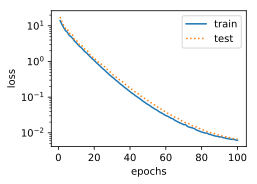

In [10]:
#三阶拟合（模型复杂度刚刚好，最合适）
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:])

3）再试试线性函数拟合。

尝试画出训练过程中模型分别在训练集和验证集上的学习曲线；观察分析这2条学习曲线，判断该模型是欠拟合，还是过拟合，还是表现很好？请说明理由，并指出改进方案。

final epoch: train loss 159.33261 test loss 102.91911
weight: [[22.648138]] 
bias: [-0.66163164]


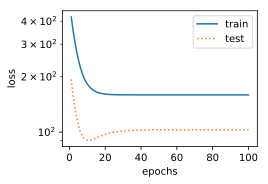

In [11]:
#线性拟合（模型太简单，会导致欠拟合）
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

4）使⽤三阶多项式函数模型来拟合，请注意，这次，只使⽤2个样本来训练模型。

①打印出最佳参数的取值，并与真实参数值进行对比，并对结果进行分析点评。

②尝试画出训练过程中模型分别在训练集和验证集上的学习曲线；观察分析这2条学习曲线，判断该模型是欠拟合，还是过拟合，还是表现很好？请说明理由，并指出改进方案。

final epoch: train loss 0.47576833 test loss 133.27455
weight: [[2.0588458 1.9273669 2.0477402]] 
bias: [2.482129]


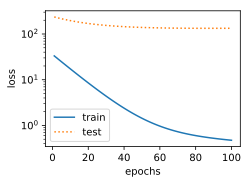

In [12]:
#三阶拟合，训练样本不足（欠拟合）
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])

5）使⽤10阶多项式函数模型来拟合。

①打印出最佳参数的取值，并与真实参数值进行对比；

②尝试画出训练过程中模型分别在训练集和验证集上的学习曲线；观察分析这2条学习曲线，判断该模型是欠拟合，还是过拟合，还是表现很好？请说明理由，并指出改进方案。

③尝试利用L2正则化技术，让该模型的表现好起来。画出训练过程中模型分别在训练集和验证集上的学习曲线；观察分析这2条学习曲线，判断该模型是欠拟合，还是过拟合，还是表现很好？并说明理由。

④打印出③中模型的最佳参数，并与①进行对比，尝试总结下L2正则化技术所带来的效果，并分析为何L2正则化技术可以解决过拟合问题。

⑤ 在③中使用不同的正则化强度，打印出不同正则化强度下的最佳参数，并对结果进行分析点评。

提示：可参照《动手学深度学习》 的“3.11.4多项式函数拟合实验”


注意：本次作业，推荐使用Scikit-learn + Python来做，可参考《机器学习实战》的教材代码。当然，如果喜欢用Tensorflow的，也可以用Tensorflow。或者其他的深度学习框架，只要兼容机器学习模型的都可以。框架和编程语言的选择，自己决定就好，不做强制性要求。 

发布时间：	2019/9/29 15:43:14
截止时间：	2019/10/8 0:00:00